In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import  minimize,NonlinearConstraint #optimization

### Fitting functions

In [2]:
# Functions and Definitions for Data fitting
COP_DATA = []         
COP_POLY_COEFFS = np.array([])  
COP_POLY_DEGREE = 3   

HEAT_POLY_COEFFS = np.array([])  # will store polynomial coefficients
HEAT_POLY_DEGREE = 3             # adjust as needed

def generate_heat_fit(heat_dict):
    global HEAT_POLY_COEFFS

    if not heat_dict:
        raise ValueError("No heat data to fit.")

    # Sort by temperature
    temps, heat_vals = zip(*sorted(heat_dict.items()))
    
    # Fit polynomial
    HEAT_POLY_COEFFS = np.polyfit(temps, heat_vals, HEAT_POLY_DEGREE)


def get_heat_from_fit(T):
    if HEAT_POLY_COEFFS is None or len(HEAT_POLY_COEFFS) == 0:
        raise RuntimeError("Heat polynomial fit has not been generated.")
    
    return float(np.polyval(HEAT_POLY_COEFFS, T))


def print_heat_fit_equation():
    terms = [f"{coef:.6g} * T^{HEAT_POLY_DEGREE - i}" 
            for i, coef in enumerate(HEAT_POLY_COEFFS)]
    equation = " + ".join(terms)
    print("Heat(T) ≈", equation)



def store_COP_data(param, T_si_in):
    cop_val = 1. / calc_COP(param)  # invert reciprocal COP
    COP_DATA.append((T_si_in, cop_val))
    return 1. / cop_val

def generate_COP_fit():
    global COP_POLY_COEFFS
    if not COP_DATA:
        raise ValueError("No COP data to fit.")
    COP_DATA.sort(key=lambda x: x[0])
    T_vals, cop_vals = zip(*COP_DATA)
    COP_POLY_COEFFS = np.polyfit(T_vals, cop_vals, COP_POLY_DEGREE)

def get_COP_from_fit(T_si_in):
    if COP_POLY_COEFFS is None or len(COP_POLY_COEFFS) == 0:
        raise RuntimeError("COP polynomial fit has not been generated.")
    return float(np.polyval(COP_POLY_COEFFS, T_si_in))

def calc_COP(param): 
    hp_vals = HP(param)

    state1 = hp_vals["state1"]

    state3= hp_vals["state3"]

    state2= hp_vals["state2"]

    #spec. heat released in the condenser
    q_high=state2["h"]-state3["h"] #kJ/kg
    #spec. compressor work
    w_comp=state2["h"]-state1["h"]  #kJ/kg
    #coefficient of performance 

    COP=q_high/w_comp
    #return reciprocal value of COP
    return 1./COP

def print_COP_fit_equation():
    if len(COP_POLY_COEFFS) == 0:
        raise RuntimeError("Fit not generated yet.")

    terms = [f"{coef:.6g} * T^{COP_POLY_DEGREE - i}" 
        for i, coef in enumerate(COP_POLY_COEFFS)]
    equation = " + ".join(terms)
    print("COP(T_si_in) ≈", equation)


### Reading in file with Heat and COP data for fitting

In [3]:
#read in textfile

def read_results_from_txt(filepath="heat_pump_results.txt"):
    results = {}
    current_dia = None
    current_fluid = None
    mode = None

    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            if line.startswith("DIA="):
                parts = line.split(", ")
                current_dia = int(parts[0].split("=")[1])
                current_fluid = parts[1].split("=")[1]

                if current_dia not in results:
                    results[current_dia] = {}

                results[current_dia][current_fluid] = {
                    "COP_DATA": [],
                    "HEAT_DATA": {}
                }

            elif line == "COP_DATA:":
                mode = "COP_DATA"

            elif line == "HEAT_DATA:":
                mode = "HEAT_DATA"

            elif line == "END_ENTRY":
                mode = None
                current_dia = None
                current_fluid = None

            elif mode == "COP_DATA":
                T, cop = map(float, line.split(","))
                results[current_dia][current_fluid]["COP_DATA"].append((T, cop))

            elif mode == "HEAT_DATA":
                T, Q = map(float, line.split(","))
                results[current_dia][current_fluid]["HEAT_DATA"][T] = Q

    return results

In [4]:
results = read_results_from_txt("heat_pump_results.txt")

COP_DATA = []
HEAT_DATA = {}

COP_DATA = results[35]['DimethylEther']['COP_DATA']

HEAT_DATA = results[35]['DimethylEther']['HEAT_DATA']

In [5]:
generate_COP_fit() #generates fit for exactly these conditions: power, diameter, refrigerant
generate_heat_fit(HEAT_DATA)

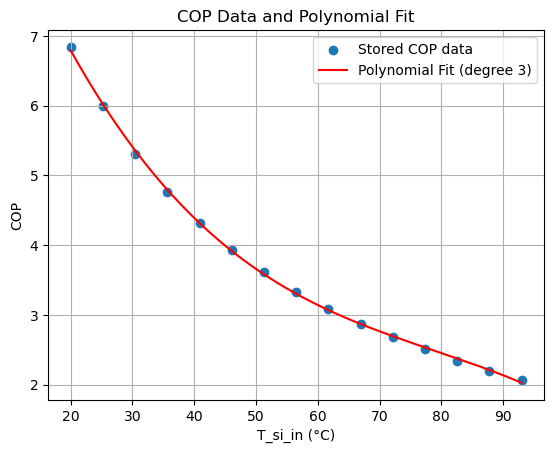

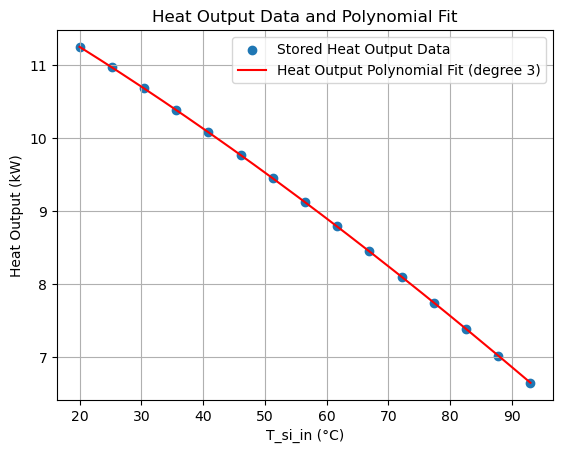

COP(T_si_in) ≈ -1.23408e-05 * T^3 + 0.00292165 * T^2 + -0.260766 * T^1 + 10.9347 * T^0
Heat(T) ≈ 2.39387e-07 * T^3 + -0.000170109 * T^2 + -0.0464024 * T^1 + 12.2433 * T^0


In [6]:
    # Plotting the data points and the fit
plt.scatter(*zip(*COP_DATA), label='Stored COP data')

T_plot = np.linspace(20,93, 200)
COP_fit_vals = [get_COP_from_fit(T) for T in T_plot]

plt.plot(T_plot, COP_fit_vals, 'r-', label='Polynomial Fit (degree {})'.format(COP_POLY_DEGREE))
plt.xlabel('T_si_in (°C)')
plt.ylabel('COP')
plt.title('COP Data and Polynomial Fit')
plt.legend()
plt.grid(True)
plt.show()

#plotting heat output data
plt.scatter(*zip(*HEAT_DATA.items()), label='Stored Heat Output Data')
T_heat_plot = np.linspace(20, 93, 200)
heat_fit_vals = [get_heat_from_fit(T) for T in T_heat_plot]
plt.plot(T_heat_plot, heat_fit_vals, 'r-', label='Heat Output Polynomial Fit (degree {})'.format(HEAT_POLY_DEGREE))
plt.xlabel('T_si_in (°C)')
plt.ylabel('Heat Output (kW)')
plt.title('Heat Output Data and Polynomial Fit')
plt.legend()
plt.grid(True)
plt.show()

#print the equations for the fits

    
print_COP_fit_equation()
print_heat_fit_equation()

## Control Strategy with heat-up included

### Defining variables

In [7]:
# --- Global control variables ---
HP = 1  # initial state of the heat pump: 1 = ON, 0 = OFF
time = 0  # timer to record operating time

# --- Constants and parameters ---
R_env = 30 / 1000    # K/W£
R_pasta = 15 / 1000  # K/W
c_l = 4.18 * 1000    # J/kg·K water
c_pasta = 3.5 * 1000 # J/kg·K pasta

T_env = 20      # °C
T_pasta_0 = 7        # °C
rho_water = 997.     # kg/m3

# --- Dimensions of the water tank ---
V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1000# L
m_water = V_water / 1e3 * rho_water  # kg
m_pasta = 2 # kg

print(V_water)

24.543288000000004


### Defining pasta cooking schedule 

In [32]:
# --- Pasta batch schedule (7 min cook, 5 min break) ---
# could also be adapted if a new schedule was needed
def make_pasta_list(t):
    #counter_heating = heating_up_time * 60  # convert to seconds
    pasta_counter = 7 * 60
    break_counter = 5 * 60
    pasta_presence = np.zeros(len(t))
    pasta_taking_out_times = np.zeros(len(t))
    
    for i in range(len(t)):
        #if counter_heating > 0:
            #counter_heating -= 1
            #pasta_presence[i] = 0
            #continue
        if pasta_counter == 0:
            pasta_taking_out_times[i] = 1
        if pasta_counter > 0:
            pasta_presence[i] = 1
            pasta_counter -= 1
        elif break_counter > 0:
            pasta_presence[i] = 0
            break_counter -= 1
        else:
            pasta_counter = 7 * 60 - 1
            break_counter = 5 * 60
            pasta_presence[i] = 1
    return pasta_presence

def make_pasta_starting_list(t):
    pasta_counter = 7 * 60
    break_counter = 5 * 60
    pasta_presence = np.zeros(len(t))
    pasta_taking_out_times = np.zeros(len(t))
    #counter_heating = heating_up_time * 60  # convert to seconds
    
    for i in range(len(t)):
        #if counter_heating > 0:
            #counter_heating -= 1
            #pasta_presence[i] = 0
            #continue
        if pasta_counter == 1:
            pasta_taking_out_times[i] = 1
        if pasta_counter > 0:
            pasta_presence[i] = 1
            pasta_counter -= 1
        elif break_counter > 0:
            pasta_presence[i] = 0
            break_counter -= 1
        else:
            pasta_counter = 7 * 60 - 1
            break_counter = 5 * 60
            pasta_presence[i] = 1
    return pasta_taking_out_times

### Define heat pump control logic

In [33]:
# --- Heat pump control logic ---
def calc_HP(T, T_on, T_off, op_times):
    global HP, time

    # time counts how long the heat pump operates for one operation
    # HP signals if the heatpump is on or off

    # If Temperature falls below minimal threshold value --> turn heat pump on
    if T <= T_on: # Temperature is below T
        if HP == 0:
            time = 0
        HP = 1

    # If Temperature is above maximum threshold --> turn heat pump off
    elif T >= T_off:
        if HP == 1:
            op_times.append(time)
        HP = 0

    # If the Heatpump is on, increase operation time and calculate heat output for the respective sink temperature with the fit
    # Else output of the heatpump is zero at this timestel
    if HP == 1:
        time += 1
        return get_heat_from_fit(T) * 1000
    else:
        return 0

### Define Temperature ODE's for system

In [34]:
# --- ODE for water only ---
def temp_store_only_water(T_water, t, Q_WP, m_water, c_water):
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env) / (m_water * c_water)
    return dT_waterdt

# --- ODE for water + pasta ---
def temp_store_with_pasta(T, t, Q_WP, m_water, m_pasta, c_water, c_pasta):
    T_water, T_pasta = T
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env - (T_water - T_pasta) / R_pasta) / (m_water * c_water)
    dT_pastadt = ((T_water - T_pasta) / R_pasta) / (m_pasta * c_pasta)
    return [dT_waterdt, dT_pastadt]

### Define the main simulation

In [35]:
# --- Main simulation ---

def T_water_and_pasta(T_WP_on, T_WP_off, duration_s,op_times, V_store=V_water):
    t = np.linspace(0, duration_s, duration_s)
    T_water = np.zeros(duration_s)
    T_pasta = np.full(duration_s, T_pasta_0)
    Q_WPs = np.zeros(duration_s)

    T0_water = T_WP_on
    T0_pasta = T_pasta_0
    T_water[0] = T0_water
    T_pasta[0] = T0_pasta

    m_store = V_store / 1e3 * rho_water
    m_pasta = 2  # kg

    binary_pasta = make_pasta_list(t)

    global WP, time
    WP = 1
    time = 0

    for i in range(1, duration_s):
        if binary_pasta[i] == 0:
            tspan = [t[i - 1], t[i]]
            z = odeint(temp_store_only_water, T0_water, tspan, args=(Q_WPs[i - 1], m_store, c_l))
            T0_water = z[1][0]
            T0_pasta = T_pasta_0
        else:
            tspan = np.linspace(t[i - 1], t[i], 10)
            T_function = [T0_water, T0_pasta]
            sol = odeint(temp_store_with_pasta, T_function, tspan, args=(Q_WPs[i - 1], m_store, m_pasta, c_l, c_pasta))
            T0_water = sol[-1, 0]
            T0_pasta = sol[-1, 1]

        Q_WPs[i] = calc_HP(T0_water, T_WP_on, T_WP_off, op_times)
        T_water[i] = T0_water
        T_pasta[i] = T0_pasta

    return t, Q_WPs, T_water, T_pasta

# --- Main simulation with morning heat-up ---
def T_water_and_pasta_with_heatup(T_WP_on, T_WP_off, V_water, duration_s, op_times, m_water, m_pasta):
    t = np.linspace(0, duration_s, duration_s)
    T_water = np.zeros(duration_s)
    T_pasta = np.full(duration_s, T_pasta_0, dtype=float)
    Q_WPs = np.zeros(duration_s)
    #Q_pasta = np.zeros(duration_s)

    T0_water = T_env  # Start at room temp
    T0_pasta = T_pasta_0
    T_water[0] = T0_water
    T_pasta[0] = T0_pasta

    binary_pasta = np.zeros(duration_s)
    
    pasta_schedule_started = False
    pasta_schedule_start_index = None

    for i in range(1, duration_s):
        if not pasta_schedule_started and T0_water >= T_WP_on:
            pasta_schedule_start_index = i
            binary_pasta[i:] = make_pasta_list(np.arange(duration_s - i))
            pasta_schedule_started = True

        if binary_pasta[i] == 0:
            tspan = [t[i - 1], t[i]]
            z = odeint(temp_store_only_water, T0_water, tspan, args=(Q_WPs[i - 1], m_water, c_l))
            T0_water = z[1][0]
            T0_pasta = T_pasta_0

        else:
            tspan = np.linspace(t[i - 1], t[i], 10)
            T_function = [T0_water, T0_pasta]
            sol = odeint(temp_store_with_pasta, T_function, tspan, args=(Q_WPs[i - 1], m_water, m_pasta, c_l, c_pasta))
            T0_water = sol[-1, 0]
            T0_pasta = sol[-1, 1]

        Q_WPs[i] = calc_HP(T0_water, T_WP_on, T_WP_off, op_times)
        T_water[i] = T0_water
        T_pasta[i] = T0_pasta
        #Q_pasta[i] = m_pasta*c_pasta*(T_pasta[i] - T_pasta[i-1])

    return t, Q_WPs, T_water, T_pasta, pasta_schedule_start_index


### Running the simulation

#### Calculate additional time needed for heating up in the morning

#### Run simulation for the 12 hours of operation including the heating up time in the morning

In [36]:


global V_water, duration_seconds, m_water, m_pasta, T_WP_on, T_WP_off, binary_pasta, binary_taking_out_pasta, start_index
duration_seconds = 12 * 60 * 60  # 12 hours
start_index = 0

t = np.linspace(0, duration_seconds, duration_seconds)  # time vector in seconds
binary_pasta = make_pasta_list(t)
binary_taking_out_pasta = make_pasta_starting_list(t)

bounds=[(85,92),(86,93)] #(T_on_min,T_on_max), (T_off_min, T_off_max)

# Constraint: water temperature minimum >= 85°C
def water_temp_min_constraint(x):
    T_WP_on, T_WP_off = x
    _, _, T_water, _, _ = T_water_and_pasta_with_heatup(T_WP_on, T_WP_off, V_water, duration_seconds, [], m_water, m_pasta)
    return np.min(T_water)

# Constraint: water temperature maximum <= 93°C
def water_temp_max_constraint(x):
    T_WP_on, T_WP_off = x
    _, _, T_water, _, _ = T_water_and_pasta_with_heatup(T_WP_on, T_WP_off, V_water, duration_seconds, [], m_water, m_pasta)
    return np.max(T_water)
def pasta_temp_at_cycle_ends_constraint(x):
    T_WP_on, T_WP_off = x
    _, _, _, T_pasta, _ = T_water_and_pasta_with_heatup(T_WP_on, T_WP_off, V_water, duration_seconds, [], m_water, m_pasta)
    
    # Find cycle end indices from the global binary list
    cycle_end_indices = np.where(binary_taking_out_pasta == 1)[0]
    
    # Get pasta temps at cycle ends
    pasta_temps_at_ends = T_pasta[cycle_end_indices]
    
    return pasta_temps_at_ends


# Define nonlinear constraints
nlc_min = NonlinearConstraint(water_temp_min_constraint, 85, 93)
nlc_max = NonlinearConstraint(water_temp_max_constraint, 85, 93)
nlc_pasta_min = NonlinearConstraint(pasta_temp_at_cycle_ends_constraint, 85, np.inf)
nlc_pasta_max = NonlinearConstraint(pasta_temp_at_cycle_ends_constraint, -np.inf, 86)

constraints = [nlc_min, nlc_max, nlc_pasta_min, nlc_pasta_max]

# Initial guess and bounds
x0 = [87, 92]


def objective(x):
    T_WP_on, T_WP_off = x
    global WP, time
    WP = 0
    time = 0
    op_times = []
    t, Q_WP, T_water, _, _ = T_water_and_pasta_with_heatup(
        T_WP_on, T_WP_off, V_water, duration_seconds, op_times, m_water, m_pasta
    )

    # Avoid divide-by-zero by setting min COP to a small positive value
    power_consumption = []
    for i in range(len(Q_WP)):
        if Q_WP[i] > 0:
            cop = max(get_COP_from_fit(T_water[i]), 0.01)
            power = Q_WP[i] / (cop * 1000)  # Convert to kW
        else:
            power = 0
        power_consumption.append(power)

    total_power = np.sum(power_consumption)
    print(f"Objective call: T_on={T_WP_on:.2f}, T_off={T_WP_off:.2f}, Total Power={total_power:.2f} kWh")
    return total_power


# --- Brute-force grid search instead of SLSQP optimization ---
T_on_vals = np.arange(85, 89.25, 1)
T_off_vals = np.arange(89, 93.25, 1)

best_result = None
best_obj = float('inf')


for T_on in T_on_vals:
    for T_off in T_off_vals:
        try:
            obj = objective([T_on, T_off])
            print(f"Checked T_on={T_on:.1f}, T_off={T_off:.1f} → Power={obj:.2f} kWh")
            if obj < best_obj:
                best_obj = obj
                best_result = (T_on, T_off)
        except Exception as e:
            print(f"⚠️ Skipping T_on={T_on:.1f}, T_off={T_off:.1f} due to error: {e}")



# Print the best result
print("\n✅ Best Result:")
print(f"T_on  = {best_result[0]:.1f} °C")
print(f"T_off = {best_result[1]:.1f} °C")
print(f"Total Heat Pump Power = {best_obj:.2f} kWh")




Objective call: T_on=85.00, T_off=89.00, Total Power=58972.68 kWh
Checked T_on=85.0, T_off=89.0 → Power=58972.68 kWh
Objective call: T_on=85.00, T_off=90.00, Total Power=59560.23 kWh
Checked T_on=85.0, T_off=90.0 → Power=59560.23 kWh
Objective call: T_on=85.00, T_off=91.00, Total Power=60944.77 kWh
Checked T_on=85.0, T_off=91.0 → Power=60944.77 kWh
Objective call: T_on=85.00, T_off=92.00, Total Power=61914.82 kWh
Checked T_on=85.0, T_off=92.0 → Power=61914.82 kWh
Objective call: T_on=85.00, T_off=93.00, Total Power=63093.12 kWh
Checked T_on=85.0, T_off=93.0 → Power=63093.12 kWh
Objective call: T_on=86.00, T_off=89.00, Total Power=60068.06 kWh
Checked T_on=86.0, T_off=89.0 → Power=60068.06 kWh
Objective call: T_on=86.00, T_off=90.00, Total Power=60694.61 kWh
Checked T_on=86.0, T_off=90.0 → Power=60694.61 kWh
Objective call: T_on=86.00, T_off=91.00, Total Power=61322.82 kWh
Checked T_on=86.0, T_off=91.0 → Power=61322.82 kWh
Objective call: T_on=86.00, T_off=92.00, Total Power=62687.13 kW

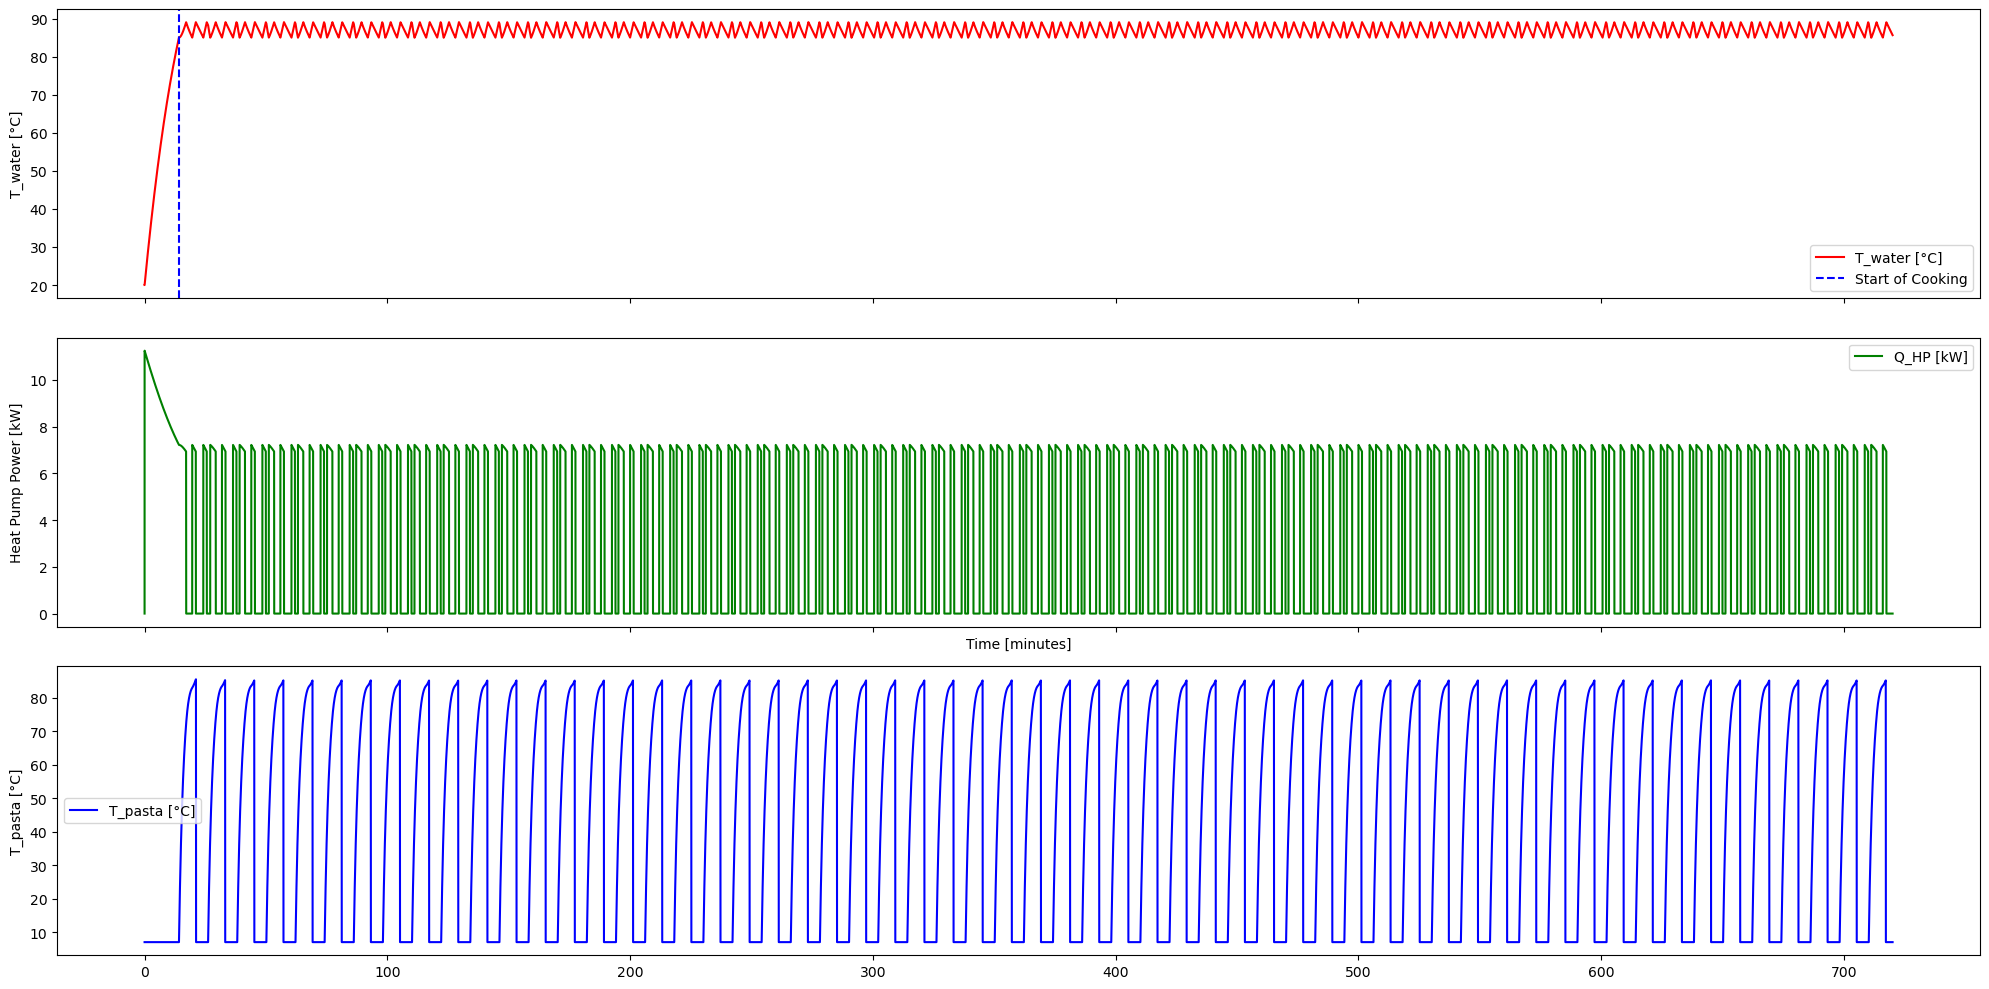

Time until cooking starts (heat-up) = 14.18 minutes
Min operating time = 1.42 minutes
Max operating time = 17.83 minutes
Number of heat pump on-cycles = 176
total_duration = 12.0 hours
Max T_water after heat-up: 89.04520456402535
Min T_water after heat-up: 84.95088161286488


In [23]:
# --- Plot results using the best found T_on and T_off ---
T_WP_on, T_WP_off = best_result

# Run simulation with best parameters
op_times = []
t, Q_WPs, T_water, T_pasta, start_index = T_water_and_pasta_with_heatup(
    T_WP_on, T_WP_off, V_water, duration_seconds, op_times, m_water, m_pasta
)

# --- Plot results ---
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(20, 10))
ax1.plot(t / 60, T_water, 'r-', label='T_water [°C]')
if start_index:
    ax1.axvline(t[start_index] / 60, color='blue', linestyle='--', label='Start of Cooking')
ax1.set_ylabel('T_water [°C]')
ax1.legend()
ax2.plot(t / 60, Q_WPs / 1000, 'g-', label='Q_HP [kW]')
ax2.set_xlabel('Time [minutes]')
ax2.set_ylabel('Heat Pump Power [kW]')
ax2.legend()
ax3.plot(t / 60, T_pasta, 'b-', label='T_pasta [°C]')
ax3.set_ylabel('T_pasta [°C]')
ax3.legend()

plt.tight_layout()
plt.show()

# --- Compute and show summary ---
min_op = round(min(op_times) / 60., 2) if op_times else 0
max_op = round(max(op_times) / 60., 2) if op_times else 0
num_cycles = len(op_times)
heatup_time_min = round(t[start_index] / 60, 2) if start_index else "N/A"
total_duration = duration_seconds / 60 / 60 

print("Time until cooking starts (heat-up) =", heatup_time_min, "minutes")
print("Min operating time =", min_op, "minutes")
print("Max operating time =", max_op, "minutes")
print("Number of heat pump on-cycles =", num_cycles)
print("total_duration =", total_duration, "hours")
print("Max T_water after heat-up:", max(T_water[start_index:]))
print("Min T_water after heat-up:", min(T_water[start_index:]))


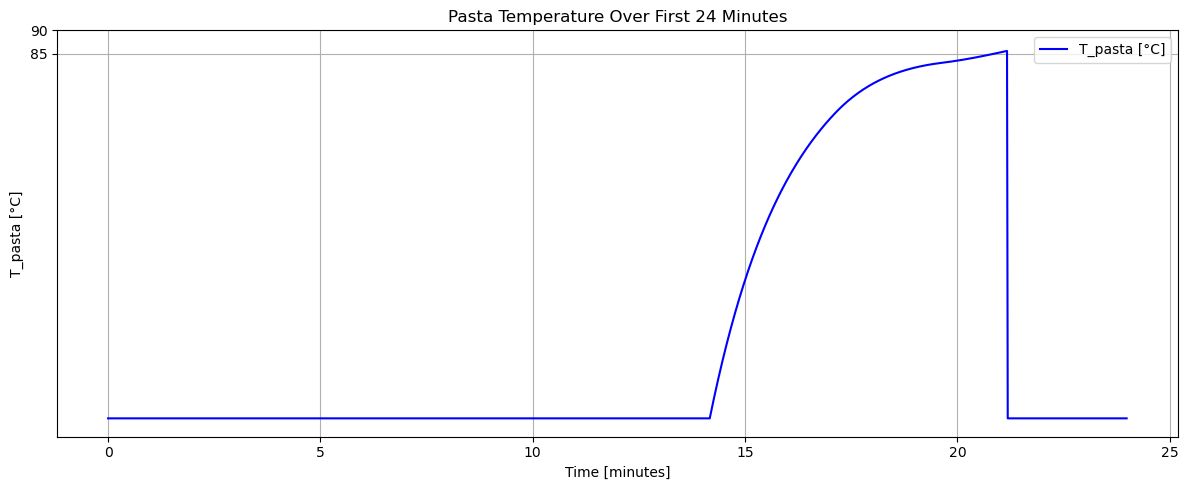

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Limit to the first 24 minutes
time_limit_minutes = 24
time_limit_seconds = time_limit_minutes * 60

# Create a mask for time ≤ 24 minutes
mask = t <= time_limit_seconds

# Apply the mask to time and temperature arrays
t_limited = t[mask]
T_pasta_limited = T_pasta[mask]

plt.figure(figsize=(12, 5))
plt.plot(t_limited / 60, T_pasta_limited, 'b-', label='T_pasta [°C]')
plt.xlabel('Time [minutes]')
plt.ylabel('T_pasta [°C]')
plt.title('Pasta Temperature Over First 24 Minutes')
plt.grid(True)
plt.legend()

# Set y-axis ticks at 85 and 90 °C
plt.yticks([85, 90])

plt.tight_layout()
plt.show()




In [25]:
print(heating_up_time)

NameError: name 'heating_up_time' is not defined

In [ ]:
#print time of pasta taking out
print("Pasta taking out times (in minutes):")


Pasta taking out times (in minutes):
